In [1]:
import pymongo
from pymongo import MongoClient
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn import preprocessing
from nbi1 import *

import warnings
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from scipy import stats

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.lines as mlines



warnings.filterwarnings('ignore')

In [2]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

def undersample(df, keyword):
    """
    It will take a dataframe and a keyword to groupby
    :input: df: Dataframe
            Key-word: column to groupby
            
    :return: undersample_df: Datafram
    
    """
    groupby_df = df.groupby([keyword]).count()
    count = min(groupby_df[groupby_df.columns[0]].tolist())
    
    tempdf_list = []

    for index in df[keyword].unique():
        tempdf_list.append(df[df[keyword] == index].sample(count)) ## Count
    
    undersample_df = pd.concat(tempdf_list)
    
    return undersample_df

def aov(df, formula):
    """
    :input: df: DataFrame
            formula: 
    
    :return: 
            Table
    """  
    model = ols(formula, df).fit()
    aov_table = anova_lm(model, typ=2)

    eta_squared(aov_table)
    return omega_squared(aov_table)
    

In [3]:
csv_file = "../data-generation/04-28-19-thesis-dataset-without-outliers_allstates"
df_wo = pd.read_csv(csv_file, index_col = 0)

In [4]:
# Arrange Dataframe is ascending order
df_wo['5 percent'] = pd.qcut(df_wo['Avg. Daily Precipitation'],[0, .05, .95, 1.], labels = ['Very Low','Medium','Very High'])
df_wo['spanlength'] = pd.qcut(df_wo['Length Of Maximum Span Flat'],[0, .1, .8, 1.], labels = ['Very Low','Medium','Very High'])

df_anova = df_wo[['Baseline Difference Score', 'ADT Category','ADTT Category','Avg. Daily Precipitation', 'State Code','5 percent',\
                       'Length Of Maximum Span Flat', 'Material','Structure Type', 'Maintainer','spanlength']]

df_anova = df_anova.rename(index=str, columns={"Baseline Difference Score": "score", \
                                               "ADT Category": "adt", \
                                               "ADTT Category": "adtt",\
                                               "Avg. Daily Precipitation": "precp", \
                                               "State Code":"region", \
                                               "5 percent": "precipitation", \
                                               "Length Of Maximum Span Flat": "lengthofspan",\
                                               "Material":"material",\
                                               "Structure Type":"structuretype",\
                                               "Maintainer":"maintainer",\
                                               "spanlength":"spanlength"
                                              })
# Northeast
N = ['09','23','25','33','44','50','34','36','42']  

# Midwest
M = ['17','18','21','39','55','19','20','27','29','31','38','46']

# South
S = ['10','12','13','24','37','45','51','11','54','01','21','28','47','05','22','40','48']

# West
W = ['04','08','16','32','30','35','49','56','01','06','15','41','53','72']

w = [int(i) for i in W]
s = [int(i) for i in S]
m = [int(i) for i in M]
n = [int(i) for i in N]

west_df_anova = df_anova[df_anova["region"].isin(w)]
west_df_anova['region'] = len(west_df_anova)*['West']

south_df_anova = df_anova[df_anova["region"].isin(s)]
south_df_anova['region'] = len(south_df_anova)*['South']

midwest_df_anova = df_anova[df_anova["region"].isin(m)]
midwest_df_anova['region'] = len(midwest_df_anova)*['Midwest']

northeast_df_anova = df_anova[df_anova["region"].isin(n)]
northeast_df_anova['region'] = len(northeast_df_anova)*['Northeast']



df_anova['precp']  =  pd.qcut(df_anova['precp'], 4, labels=["Very Light", "Light", "Moderate","Heavy"])

df_anova = pd.concat([west_df_anova,midwest_df_anova,south_df_anova,northeast_df_anova])

In [8]:
df_anova.head()

,score,adt,adtt,precp,region,precipitation,lengthofspan,material,structuretype,maintainer,spanlength
5,0.634804,Very Light,Light,0.87,West,Very Low,16.2,7,2,1,Medium
14,-0.372016,Moderate,Light,0.94,West,Very Low,12.2,5,2,1,Medium
70,0.212986,Light,Light,0.87,West,Very Low,6.1,7,2,1,Very Low
204,0.705799,Light,Light,0.70,West,Very Low,8.0,7,2,1,Medium
308,-1.193633,Moderate,Light,0.70,West,Very Low,61.0,3,10,80,Very High


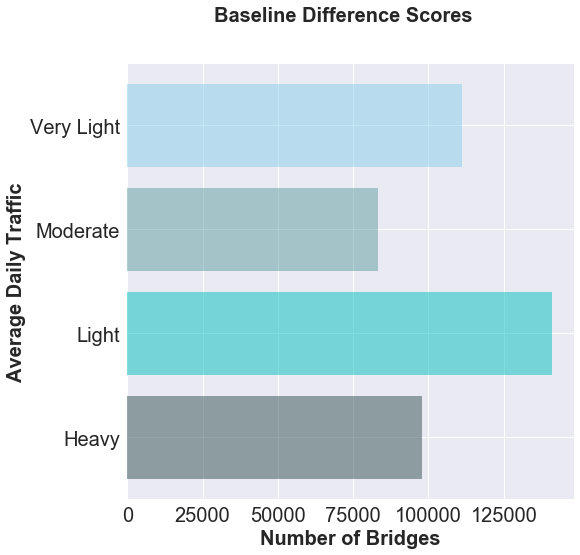

In [9]:
count_adt = df_anova.groupby('adt')['score'].count()

# Plotting 
plt.figure(figsize=(8,8))
plt.suptitle("Baseline Difference Scores", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

#Subplot 1
labels = ["Very Light", "Light", "Moderate", "Heavy"]
no_of_records = [count_adt[3], count_adt[1], count_adt[2], count_adt[0]]
plt.barh(labels, no_of_records, align = 'center', alpha = 0.5, color = ['skyblue','c','cadetblue','darkslategray'])
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.ylabel("Average Daily Traffic", fontweight = 'bold', fontsize = 20)
plt.xlabel("Number of Bridges", fontweight = 'bold', fontsize = 20)
plt.show()

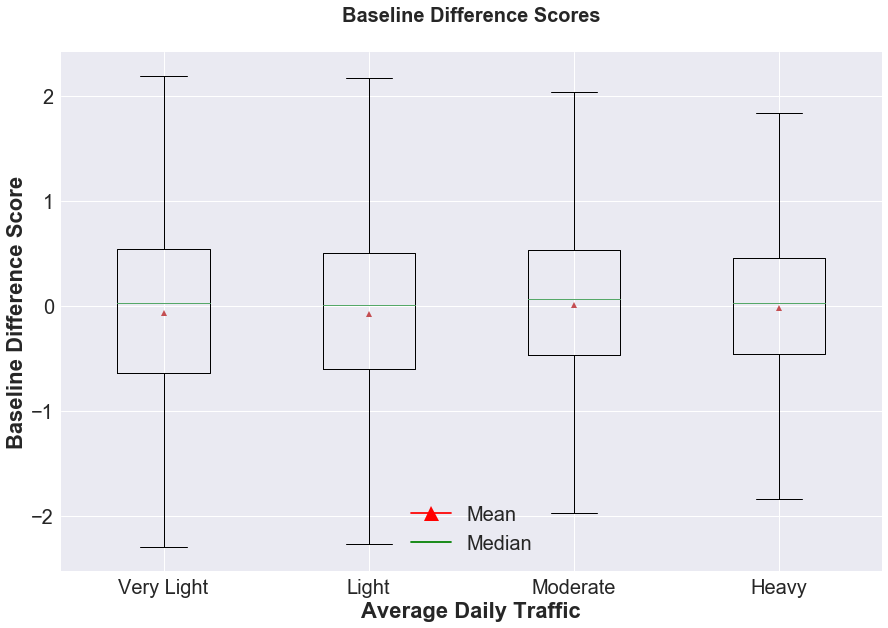

In [10]:
scores_verylight = df_anova[df_anova['adt'] == 'Very Light']['score']
scores_light = df_anova[df_anova['adt'] == 'Light']['score']
scores_moderate = df_anova[df_anova['adt'] == 'Moderate']['score']
scores_heavy = df_anova[df_anova['adt'] == 'Heavy']['score']

scores_adt = [scores_verylight, scores_light, scores_moderate, scores_heavy]


green_line = mlines.Line2D([], [], color='Green',
                          markersize=15, label='Median')
red_triangle = mlines.Line2D([], [], color='Red', marker='^',
                          markersize=15, label='Mean')




# Plotting 
plt.figure(figsize=(12,8))
plt.subplots_adjust(bottom=0, left=0.025, top = 0.9, right=0.975)
plt.suptitle("Baseline Difference Scores", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

plt.boxplot(scores_adt, labels = labels, showfliers=True, showmeans=True)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel("Average Daily Traffic", fontweight = 'bold')
plt.ylabel("Baseline Difference Score", fontweight = 'bold')

red_patch = mpatches.Patch(color='red', label='The red data')
green_patch = mpatches.Patch(color='green', label='The red data')
plt.legend(handles=[red_triangle, green_line])

plt.show()

#### ANOVA - Small Sample

In [11]:
adt = df_anova.groupby('adt').apply(lambda s: s.sample(100))['adt'].tolist()
score = df_anova.groupby('adt').apply(lambda s: s.sample(100))['score'].tolist()
df_adt_sample_100 = pd.DataFrame({'adt':adt, 'score':score})
formula = 'score ~ C(adt)'
adt_undersample = undersample(df_adt_sample_100, 'adt')
aov(adt_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(adt),2.785725,3.0,1.441858,0.230113,0.010805,0.003303
Residual,255.029053,396.0,NaN,NaN,NaN,NaN


#### ANOVA - Large Sample

In [12]:
formula = 'score ~ C(adt)'
adt_undersample = undersample(df_anova, 'adt')
aov(adt_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(adt),428.577528,3.0,221.458999,1.546106e-143,0.001988,0.001979
Residual,215145.110919,333516.0,NaN,NaN,NaN,NaN


### Results of Deck  

In [13]:
csv_file = "../data-generation/06-17-19-thesis-dataset-without-outliers_all_states_no_constant_deck"
df_wo = pd.read_csv(csv_file, index_col = 0)

In [14]:
# Arrange Dataframe is ascending order
df_wo['5 percent'] = pd.qcut(df_wo['Avg. Daily Precipitation'],[0, .05, .95, 1.], labels = ['Very Low','Medium','Very High'])
df_wo['spanlength'] = pd.qcut(df_wo['Length Of Maximum Span Flat'],[0, .1, .8, 1.], labels = ['Very Low','Medium','Very High'])

df_anova = df_wo[['Baseline Difference Score', 'ADT Category','ADTT Category','Avg. Daily Precipitation', 'State Code','5 percent',\
                       'Length Of Maximum Span Flat', 'Material','Structure Type', 'Maintainer','spanlength']]

df_anova = df_anova.rename(index=str, columns={"Baseline Difference Score": "score", \
                                               "ADT Category": "adt", \
                                               "ADTT Category": "adtt",\
                                               "Avg. Daily Precipitation": "precp", \
                                               "State Code":"region", \
                                               "5 percent": "precipitation", \
                                               "Length Of Maximum Span Flat": "lengthofspan",\
                                               "Material":"material",\
                                               "Structure Type":"structuretype",\
                                               "Maintainer":"maintainer",\
                                               "spanlength":"spanlength"
                                              })
# Northeast
N = ['09','23','25','33','44','50','34','36','42']  

# Midwest
M = ['17','18','21','39','55','19','20','27','29','31','38','46']

# South
S = ['10','12','13','24','37','45','51','11','54','01','21','28','47','05','22','40','48']

# West
W = ['04','08','16','32','30','35','49','56','01','06','15','41','53','72']

w = [int(i) for i in W]
s = [int(i) for i in S]
m = [int(i) for i in M]
n = [int(i) for i in N]

west_df_anova = df_anova[df_anova["region"].isin(w)]
west_df_anova['region'] = len(west_df_anova)*['West']

south_df_anova = df_anova[df_anova["region"].isin(s)]
south_df_anova['region'] = len(south_df_anova)*['South']

midwest_df_anova = df_anova[df_anova["region"].isin(m)]
midwest_df_anova['region'] = len(midwest_df_anova)*['Midwest']

northeast_df_anova = df_anova[df_anova["region"].isin(n)]
northeast_df_anova['region'] = len(northeast_df_anova)*['Northeast']



df_anova['precp']  =  pd.qcut(df_anova['precp'], 4, labels=["Very Light", "Light", "Moderate","Heavy"])

df_anova = pd.concat([west_df_anova,midwest_df_anova,south_df_anova,northeast_df_anova])

In [15]:
df_anova.head()

,score,adt,adtt,precp,region,precipitation,lengthofspan,material,structuretype,maintainer,spanlength
5,0.482399,Very Light,Light,0.87,West,Very Low,16.2,7,2,1,Medium
14,-0.452003,Moderate,Light,0.94,West,Very Low,12.2,5,2,1,Medium
70,-1.353042,Light,Light,0.87,West,Very Low,6.1,7,2,1,Very Low
196,-0.764630,Light,Light,0.70,West,Very Low,7.6,7,2,1,Medium
204,-0.655212,Light,Light,0.70,West,Very Low,8.0,7,2,1,Medium


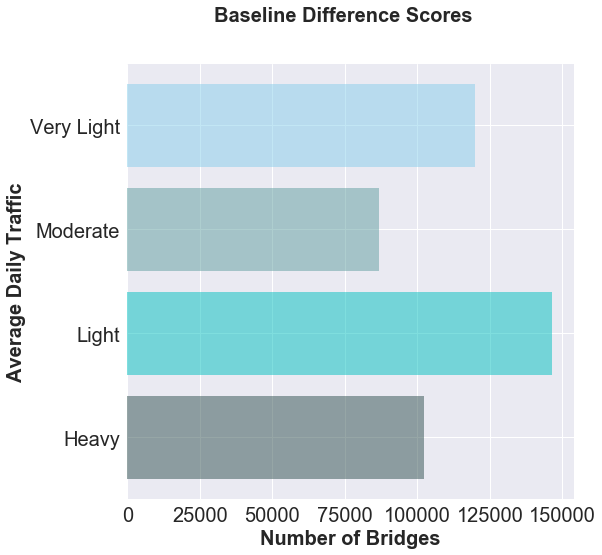

In [16]:
count_adt = df_anova.groupby('adt')['score'].count()

# Plotting 
plt.figure(figsize=(8,8))
plt.suptitle("Baseline Difference Scores", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

#Subplot 1
labels = ["Very Light", "Light", "Moderate", "Heavy"]
no_of_records = [count_adt[3], count_adt[1], count_adt[2], count_adt[0]]
plt.barh(labels, no_of_records, align = 'center', alpha = 0.5, color = ['skyblue','c','cadetblue','darkslategray'])
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.ylabel("Average Daily Traffic", fontweight = 'bold', fontsize = 20)
plt.xlabel("Number of Bridges", fontweight = 'bold', fontsize = 20)
plt.show()

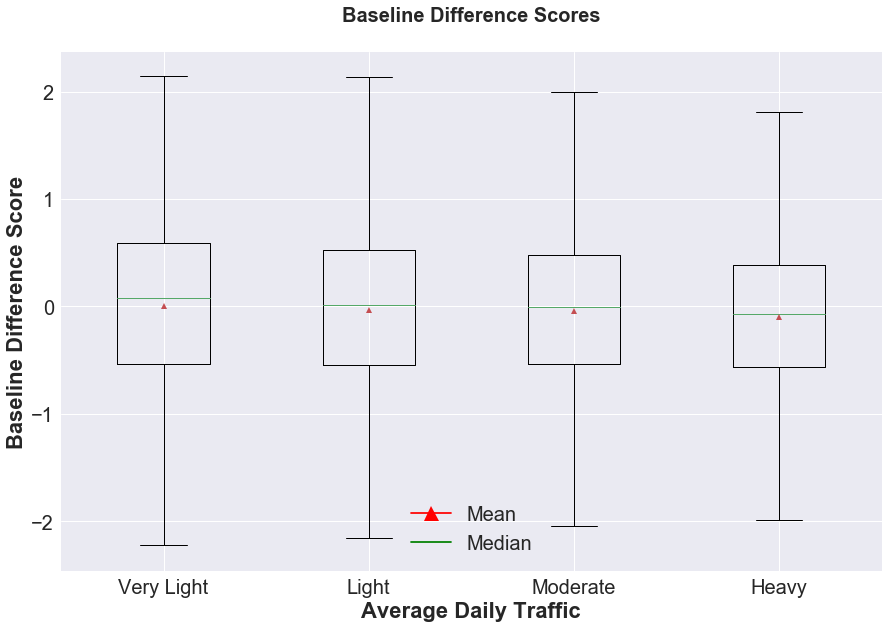

In [17]:
scores_verylight = df_anova[df_anova['adt'] == 'Very Light']['score']
scores_light = df_anova[df_anova['adt'] == 'Light']['score']
scores_moderate = df_anova[df_anova['adt'] == 'Moderate']['score']
scores_heavy = df_anova[df_anova['adt'] == 'Heavy']['score']

scores_adt = [scores_verylight, scores_light, scores_moderate, scores_heavy]


green_line = mlines.Line2D([], [], color='Green',
                          markersize=15, label='Median')
red_triangle = mlines.Line2D([], [], color='Red', marker='^',
                          markersize=15, label='Mean')




# Plotting 
plt.figure(figsize=(12,8))
plt.subplots_adjust(bottom=0, left=0.025, top = 0.9, right=0.975)
plt.suptitle("Baseline Difference Scores", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

plt.boxplot(scores_adt, labels = labels, showfliers=True, showmeans=True)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.xlabel("Average Daily Traffic", fontweight = 'bold')
plt.ylabel("Baseline Difference Score", fontweight = 'bold')

red_patch = mpatches.Patch(color='red', label='The red data')
green_patch = mpatches.Patch(color='green', label='The red data')
plt.legend(handles=[red_triangle, green_line])

plt.show()

### Small Sample

In [18]:
adt = df_anova.groupby('adt').apply(lambda s: s.sample(100))['adt'].tolist()
score = df_anova.groupby('adt').apply(lambda s: s.sample(100))['score'].tolist()
df_adt_sample_100 = pd.DataFrame({'adt':adt, 'score':score})
formula = 'score ~ C(adt)'
adt_undersample = undersample(df_adt_sample_100, 'adt')
aov(adt_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(adt),2.202305,3.0,1.074348,0.359786,0.008073,0.000557
Residual,270.586720,396.0,NaN,NaN,NaN,NaN


### Large Sample 

In [19]:
formula = 'score ~ C(adt)'
adt_undersample = undersample(df_anova, 'adt')
aov(adt_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(adt),460.207472,3.0,249.304949,1.275836e-161,0.002147,0.002138
Residual,213900.235983,347624.0,NaN,NaN,NaN,NaN
